# JAX笔记

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import random
import jax
import numpy as np
import torch

## PRNG 的设计思想

伪随机数发生器（PRNG），也被称为确定性随机位产生器（DRBG），它是一种算法，用于产生性质近似的随机数。PRNG 生成的序列不是真正随机的，因为它完全由初始值决定，称为 PRNG 的种子
> https://en.wikipedia.org/wiki/Pseudorandom_number_generator

与NumPy 和 SciPy 的"有状态"伪随机数生成器 (PRNG)不同，JAX 随机函数都需要将显式 PRNG 状态作为第一个参数传递到函数中。随机状态由两个无符号 32 位整数描述，称为key，通常由jax.random.PRNGKey()函数生成

JAX PRNG的设计要求是“可并行”的，并确保“可重复”性，因此需要将随机数种子以参数的形式传入到函数中。

In [72]:
key = jax.random.PRNGKey(0)
print("key:",key)
print("Random value:",jax.random.uniform(key))

key: [0 0]
Random value: 0.41845703


如果你需要一个新的随机数，你可以用它jax.random.split()来生成新的子密钥：

In [73]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
print("key:",key)
print(jax.random.uniform(key))
print("subkey:",subkey)
print(jax.random.uniform(subkey))

key: [4146024105  967050713]
0.5572065
subkey: [2718843009 1272950319]
0.10536897


## JAX求梯度（grad）

In [173]:
def sum_of_squares(x):
    return jnp.sum(x**2)

In [181]:
x = jnp.arange(3.0)
y = sum_of_squares(x)
print("x:",x)
print("y:",y)

x: [0. 1. 2.]
y: 5.0


In [182]:
jax.grad(sum_of_squares)( jnp.asarray(x.tolist()))

DeviceArray([0., 2., 4.], dtype=float32)

## 使用JAX实现的线性回归



### 简单线性回归

In [280]:
features = np.random.normal(size=(10,))
noise = np.random.normal(scale=0.1, size=(10,))
y = features * 3 - 1 + noise

In [286]:
learning_rate = 0.1

def predict(params,X):
    W,b = params
    return X*W+b
    
def squared_loss(params, X, y):
    y_hat = predict(params,X)
    return jnp.mean((y-y_hat.reshape(y.shape))**2)

params = jnp.array([1., 1.])

print("更新前w,b:",params,"loss =",squared_loss(params,features,y))
params = params - learning_rate * jax.grad(squared_loss)(params,features,y)
print("更新后w,b:",params,"loss =",squared_loss(params,features,y))

更新前w,b: [1. 1.] loss = 8.90182
更新后w,b: [1.4026248 0.5087129] loss = 5.327842


w,b: [ 2.9808729  -0.97643864] loss = 0.006122653


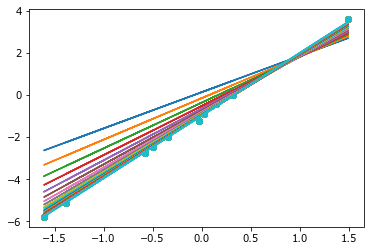

In [287]:
for _ in range(20):
    params = params - learning_rate * jax.grad(squared_loss)(params,features,y)
    plt.scatter(features, y)
    plt.plot(features, predict(params,features))
print("w,b:",params,"loss =",squared_loss(params,features,y))

### 较复杂的线性回归

在这个例子中，假设X具有三个属性

In [4]:
features = np.random.normal(size=(10,3))
w_real = np.random.normal(size=(3,1))
b_real = np.random.normal(size=(10,1))
noise = np.random.normal(scale=0.1, size=(10,1))
y = np.matmul(features,w_real)+b_real+noise
y

array([[-0.07768128],
       [ 0.76405741],
       [ 1.3041409 ],
       [-0.92663122],
       [-0.02784093],
       [-0.80102919],
       [-2.57386402],
       [ 0.42506159],
       [ 0.77430163],
       [-1.64938475]])

In [40]:
learning_rate = 0.1

def predict(params,X):
    W,b = params
    return jnp.matmul(X,W)+b

def squared_loss(params, X, y):
    y_hat = predict(params,X)
    return jnp.mean((y-y_hat.reshape(y.shape))**2)


key = jax.random.PRNGKey(0)
key1, key2 = jax.random.split(key, 2)

W = jax.random.normal(key1, (3, 1))
b = jax.random.normal(key2, (10,1))
params = [W,b]

print("更新前w,b:",params,"loss =",squared_loss(params,features,y))

grads = jax.grad(squared_loss)(params,features,y)
params = [params[0] - learning_rate * grads[0], params[1] - learning_rate * grads[1]]

print("更新后w,b:",params,"loss =",squared_loss(params,features,y))

更新前w,b: [DeviceArray([[ 0.13893168],
             [ 0.509335  ],
             [-0.53116107]], dtype=float32), DeviceArray([[-0.38812608],
             [-0.04487164],
             [-2.0427258 ],
             [ 0.07932311],
             [ 0.33349916],
             [ 0.7959976 ],
             [-1.4411978 ],
             [-1.6929979 ],
             [-0.37369204],
             [-1.5401139 ]], dtype=float32)] loss = 3.3276212
更新后w,b: [DeviceArray([[ 0.08073936],
             [ 0.29873985],
             [-0.48158327]], dtype=float32), DeviceArray([[-0.36889294],
             [-0.04552448],
             [-1.9595271 ],
             [ 0.06473079],
             [ 0.31370008],
             [ 0.7621331 ],
             [-1.4548105 ],
             [-1.6469178 ],
             [-0.32975566],
             [-1.5453378 ]], dtype=float32)] loss = 2.743939


In [39]:
%%time
for _ in range(20):
    grads = jax.grad(squared_loss)(params,features,y)
    params = [params[0] - learning_rate * grads[0], params[1] - learning_rate * grads[1]]
print("w,b:",params,"loss =",squared_loss(params,features,y))

w,b: [DeviceArray([[-0.21983534],
             [-0.6499963 ],
             [-0.03816024]], dtype=float32), DeviceArray([[-0.35996518],
             [ 0.80396914],
             [ 0.13568763],
             [-1.0924063 ],
             [ 0.49793577],
             [-1.0341266 ],
             [-2.154087  ],
             [-0.44372064],
             [-0.09831703],
             [-0.7453041 ]], dtype=float32)] loss = 0.028454727
Wall time: 240 ms
